In [1]:
import numpy as np
import sys
import platform 
system = platform.system()
if system == 'Linux':
    sys.path.append('/home/lucas/Documents/Log_Analysis/Battery')
elif system == 'Darwin':
    sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis')
import analog
import matplotlib.pyplot as plt

In [2]:
import platform 
if platform.system() == 'Linux':
    folder = '/home/lucas/Documents/Log_Analysis/Logs/Snow Orange (Battery 9) z0=1'
if platform.system() == 'Darwin':
    folder = '/Users/Lucas/Documents/Travail/Yuneec/Logs/Snow Orange (Battery 9) z0=1'
log_file = analog.pathfromQGC(folder,index=195)
info = analog.logextract(log_file,'battery_status')

In [3]:
u = info['battery_current']
u = np.reshape(u,(len(u),1))
print(np.shape(u))
t = info['time_bs']
y = info['battery_voltage']/4
y = np.reshape(y,(len(y),1))
print(np.shape(y))

(30348, 1)
(30348, 1)


In [4]:
u=u[t>60]
y=y[t>60]
t=t[t>60]

In [5]:
N = 1500
twoi = 4000 # i>n, the system order
i = int(twoi/2)
step = 5 # downsamplig factor (1 is no downsampling)
print(len(u))

29248


In [6]:
u = u[slice(1,len(u),step)]
y = y[slice(1,len(y),step)]
t = t[slice(1,len(t),step)]

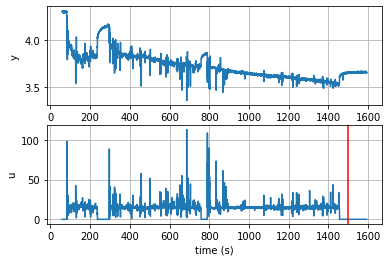

In [7]:
plt.figure()
plt.subplot(211)
plt.plot(t,y)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('y')

plt.subplot(212)
plt.plot(t,u)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('u')
plt.axvline(t[twoi+N-1],color='r')
plt.show()

In [8]:
# block Hankel control matrix

U = u[:twoi]

for n in range(N-1):
    #print(f'n={n}')
    #print(np.shape(U))
    U = np.hstack([U,u[n:twoi+n]])
    #print(U)

In [9]:
print(f'U is {np.shape(U)}')

U is (4000, 1500)


In [10]:
# block Hankel observation matrix

Y = y[:twoi]

for n in range(N-1):
    #print(f'n={n}')
    Y = np.hstack([Y,y[n:twoi+n]])
    #print(U)

In [11]:
print(f'Y is {np.shape(Y)}')

Y is (4000, 1500)


In [12]:
Up = U[0:i,:] # past inputs
Uf = U[i:,:] # future inputs 
Yp = Y[0:i,:] # past outputs
Yf = Y[i:,:] # future outputs

In [13]:
print(f'Up is {np.shape(Up)}')
print(f'Yp is {np.shape(Yp)}')

Wp = np.vstack([Up,Yp])
print(f'Uf is {np.shape(Uf)}')
print(f'pinv(Uf*Uf.T) is {np.shape(np.linalg.pinv(Uf@Uf.T))}')
PiUf = Uf.T@np.linalg.pinv(Uf@Uf.T)@Uf
print(f'Id is {np.shape(np.identity(np.shape(Uf)[0]))}')
print(f'PiUf is {np.shape(PiUf)}')
PiUfortho = np.identity(np.shape(PiUf)[0]) - PiUf

Up is (2000, 1500)
Yp is (2000, 1500)
Uf is (2000, 1500)
pinv(Uf*Uf.T) is (2000, 2000)
Id is (2000, 2000)
PiUf is (1500, 1500)


In [19]:
print(f'Yf is {np.shape(Yf)}')
print(f'Wp is {np.shape(Wp)}') # should be 2i long
print(f'PiUfortho is {np.shape(PiUfortho)}')
ksi = (Yf@PiUfortho)@np.linalg.pinv((Wp@PiUfortho))@Wp 
u,s,vh = np.linalg.svd(ksi,compute_uv=True)

Yf is (2000, 1500)
Wp is (4000, 1500)
PiUfortho is (1500, 1500)


In [47]:
print(f'ksi is {np.shape(ksi)}')
print(f'u is {np.shape(u)}')
print(f's is {np.shape(s)}')
print(f'vh is {np.shape(vh)}')
if i<N :
    Sigma = np.hstack([np.diag(s), np.zeros((i,N-i))])
elif N<i :
    Sigma = np.vstack([np.diag(s), np.zeros((i-N,N))])
else : 
    Sigma = np.diag(s)
print(f'Sigma is {np.shape(Sigma)}')
print(f'maximal error is {np.max(ksi-u@Sigma@vh)}')

ksi is (2000, 1500)
u is (2000, 2000)
s is (1500,)
vh is (1500, 1500)
Sigma is (2000, 1500)
maximal error is 9.028333636251773e-13


<IPython.core.display.Javascript object>


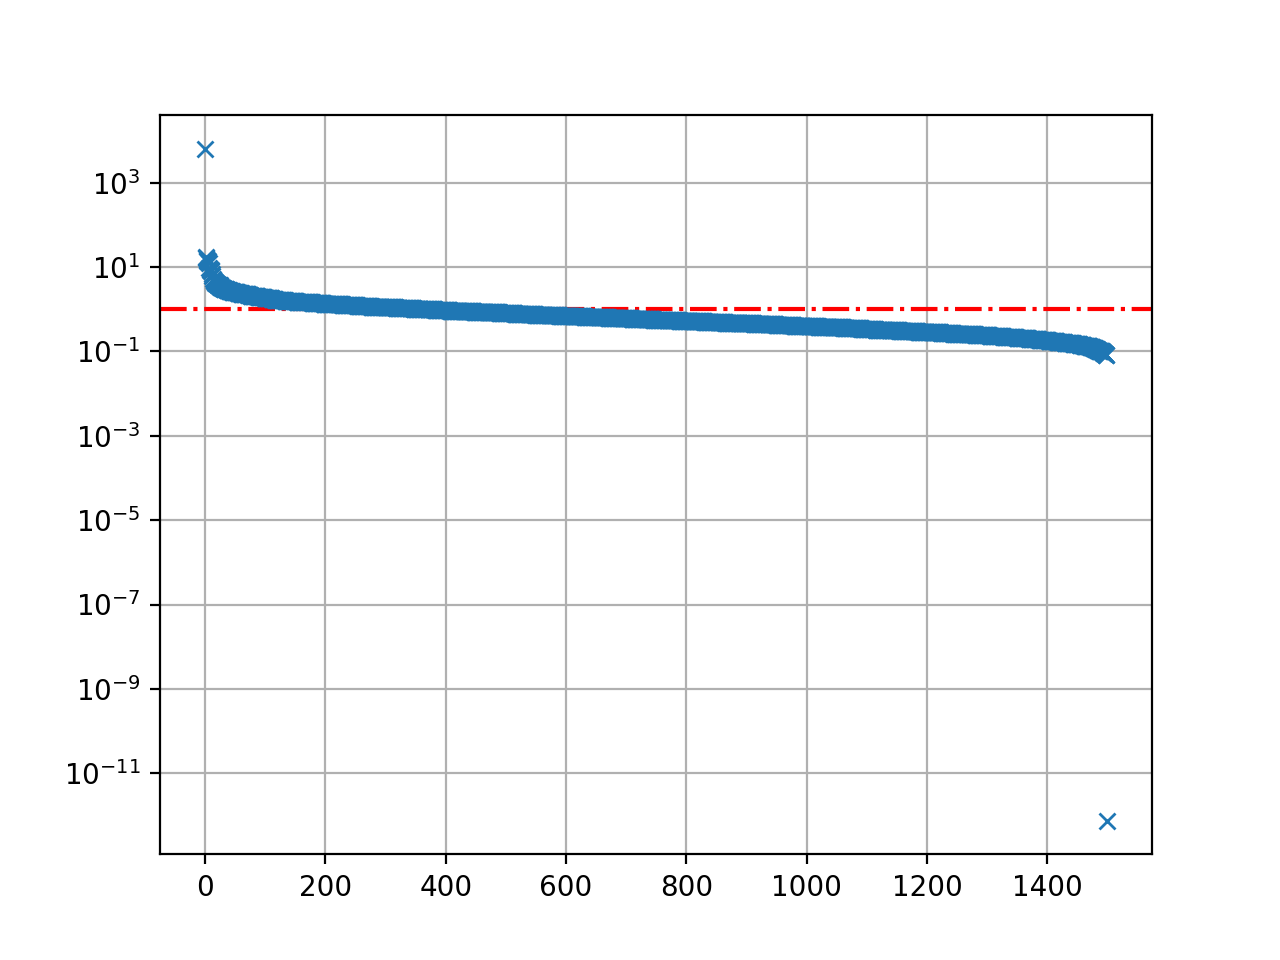

In [48]:
%matplotlib notebook
plt.figure()
plt.axhline(1,color='r',LineStyle='-.')
plt.semilogy(s,'x')
plt.grid()

In [49]:
print(f'Order to be retained is {np.shape(s[s>1])[0]}')
print(s[s>1])

Order to be retained is 366
[6.30803536e+03 1.76356679e+01 1.63902765e+01 1.47123426e+01
 1.35973297e+01 1.34941894e+01 1.20951708e+01 9.28324221e+00
 8.31933799e+00 8.28539479e+00 7.95916423e+00 6.65838206e+00
 6.00976981e+00 5.08700969e+00 4.63361667e+00 4.62180588e+00
 4.31956530e+00 4.22355519e+00 4.14685244e+00 3.98305042e+00
 3.97245330e+00 3.79595460e+00 3.77377078e+00 3.67048607e+00
 3.64885924e+00 3.35829998e+00 3.35463533e+00 3.27150461e+00
 3.17950733e+00 3.17520680e+00 3.09971908e+00 3.04778919e+00
 2.97520946e+00 2.97278246e+00 2.96922878e+00 2.92842505e+00
 2.91746809e+00 2.91470568e+00 2.84280511e+00 2.81248784e+00
 2.71799634e+00 2.69558863e+00 2.66222840e+00 2.65545322e+00
 2.62086297e+00 2.61170258e+00 2.56414980e+00 2.55834612e+00
 2.54604521e+00 2.52007770e+00 2.50421049e+00 2.50271754e+00
 2.49442869e+00 2.49057056e+00 2.47130812e+00 2.45814636e+00
 2.40403508e+00 2.40007333e+00 2.36967397e+00 2.36847359e+00
 2.34444507e+00 2.33831884e+00 2.33695459e+00 2.33315558e

In [54]:
Oi = u@np.sqrt(Sigma)
Xdf = np.linalg.pinv(Oi)@ksi

In [58]:
A = np.linalg.pinv(Oi[:-1,:])@Oi[1:,:]
C = Oi[0,:]